In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import spearmanr, pearsonr
pd.set_option('display.width', 2000)

In [22]:
nucleus_df = pd.read_csv('csv/nuclei_g4.csv')
print(nucleus_df['Location'].unique())


['DG' 'Undefined' 'CA3']


In [23]:

#nucleus_df = nucleus_df[nucleus_df['CellType'].isin(['neunPositive', 'neunPositiveLow'])]
nucleus_df['CellType'] = nucleus_df['CellType'].replace('neunPositiveLow', 'neunPositive')
# Assuming 'df' is your DataFrame
print(nucleus_df[nucleus_df['ImageName'].str.contains('MIX2')])
nucleus_df.loc[nucleus_df['ImageName'].str.contains('MIX2'), 'Ch3Intensity'] = nucleus_df.loc[nucleus_df['ImageName'].str.contains('MIX2'), 'Ch2Intensity']
print(nucleus_df[nucleus_df['ImageName'].str.contains('MIX2')])
print(nucleus_df)
print(len(nucleus_df[nucleus_df['CellType']=='neunPositiveLow']))
print(nucleus_df['Location'].unique())

Empty DataFrame
Columns: [Condition, ImageName, Label, Area, Centroid, CellType, Location, Ch1Intensity, Ch2Intensity, Ch3Intensity, Ch4Intensity, CytoCh1Intensity, CytoCh2Intensity, CytoCh3Intensity, CytoCh4Intensity]
Index: []
Empty DataFrame
Columns: [Condition, ImageName, Label, Area, Centroid, CellType, Location, Ch1Intensity, Ch2Intensity, Ch3Intensity, Ch4Intensity, CytoCh1Intensity, CytoCh2Intensity, CytoCh3Intensity, CytoCh4Intensity]
Index: []
       Condition                                          ImageName  Label    Area                                           Centroid      CellType   Location  Ch1Intensity  Ch2Intensity  Ch3Intensity  Ch4Intensity  CytoCh1Intensity  CytoCh2Intensity  CytoCh3Intensity  CytoCh4Intensity
0         Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...      1  1311.0  (3.887109077040427, 2341.739893211289, 2699.13...  neunPositive         DG     30.109077      0.247902     42.160183     52.469108               NaN               NaN     

   Condition                                          ImageName      CellType  Ch3Intensity
0     Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...     Undefined     64.614256
1     Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...  neunPositive     74.958347
2     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...     Undefined     51.222869
3     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...  neunPositive     62.445271
4     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...     Undefined     51.658729
5     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...  neunPositive     63.903068
6     Contra  HI 3 Contralateral Mouse 10 Slide18 G4green Ne...     Undefined     44.510877
7     Contra  HI 3 Contralateral Mouse 10 Slide18 G4green Ne...  neunPositive     50.415409
8       Ipsi  HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...     Undefined     65.326755
9       Ipsi  HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...  neunPositive   

/Users/jonas/miniforge3/envs/naparienv2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonas/miniforge3/envs/naparienv2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


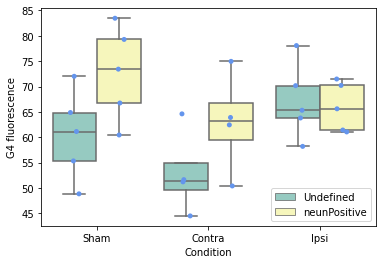

In [46]:
order =['Sham', 'Contra', 'Ipsi']

mean_ch3_intensity = nucleus_df.groupby(['Condition', 'ImageName', 'CellType'])['Ch3Intensity'].mean().reset_index()
mean_ch3_intensity = mean_ch3_intensity.drop([16,17,20,21])
#mean_ch3_intensity = mean_ch3_intensity.drop(10)

palette = sns.color_palette(['royalblue'], 2)

print(mean_ch3_intensity)
boxplot = sns.boxplot(data=mean_ch3_intensity, showfliers = False, x='Condition', y='Ch3Intensity', hue='CellType',order=order, palette='Set3')
stripplot = sns.stripplot(data=mean_ch3_intensity, x='Condition', y='Ch3Intensity', order=order, dodge=True, hue='CellType', palette=palette)
handles, labels = boxplot.get_legend_handles_labels()

# Create custom legend
plt.legend(handles=handles[:2], labels=labels[:2])
plt.ylabel('G4 fluorescence')
plt.savefig('plots/g4NeuronsNoOutliers.pdf')
plt.show()

In [21]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(mean_ch3_intensity.keys())

anova_results = f_oneway(mean_ch3_intensity[mean_ch3_intensity['Condition'] == 'Contra']['Ch3Intensity'],
                         mean_ch3_intensity[mean_ch3_intensity['Condition'] == 'Ipsi']['Ch3Intensity'],
                         mean_ch3_intensity[mean_ch3_intensity['Condition'] == 'Sham']['Ch3Intensity'])

# Perform Tukey HSD post hoc test
tukey_results = pairwise_tukeyhsd(mean_ch3_intensity['Ch3Intensity'], mean_ch3_intensity['Condition'])

print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

print("\nTukey HSD Results:")
print(tukey_results)

Index(['Condition', 'ImageName', 'CellType', 'Ch3Intensity'], dtype='object')
ANOVA Results:
F-statistic: 0.19089177328272944
p-value: 0.8273274236139758

Tukey HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
Contra   Ipsi  -0.9735 0.9905 -19.3299  17.383  False
Contra   Sham    2.971 0.9089 -14.6925 20.6344  False
  Ipsi   Sham   3.9444 0.8265 -12.6254 20.5142  False
-----------------------------------------------------
